# Parte 2
## Logistic Regression

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
# Encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
# Busqueda de Hiper-parametros
from sklearn.model_selection import RandomizedSearchCV
# TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
np.random.seed(seed=27)

In [30]:
train_df = pd.read_parquet('/content/drive/MyDrive/Orga Datos/TP3/TP3-OK/train.parquet')
test_df = pd.read_parquet('/content/drive/MyDrive/Orga Datos/TP3/TP3-OK/test.parquet')

train_df.content.fillna(' ', inplace=True)
test_df.content.fillna(' ', inplace=True)

In [31]:
X = train_df[train_df.columns[2:-2]] # no incluyo la url, timedelta, ni las surprise
y = train_df[train_df.columns[-2]] # col popular (la que quiero predecir)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Encodeo content con TfidfVectorizer

In [34]:
stop_words = set(stopwords.words('english'))

In [35]:
content_list_X_train = X_train['content'].to_list()
tf_idf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words, analyzer="word", max_features=5)

In [36]:
tf_idf_matrix_X_train = tf_idf_vectorizer.fit_transform(content_list_X_train)
tf_idf_array_X_train = tf_idf_matrix_X_train.toarray()

In [37]:
most_common_words_X_train_df = pd.DataFrame(tf_idf_array_X_train, columns=tf_idf_vectorizer.get_feature_names_out())

In [38]:
X_train = pd.concat([X_train.reset_index(), most_common_words_X_train_df.reset_index()], axis=1)

In [39]:
X_train = X_train.drop(columns=['index', 'content'])

In [40]:
content_list_X_test = X_test['content'].to_list()

In [41]:
tf_idf_matrix_X_test = tf_idf_vectorizer.transform(content_list_X_test)
tf_idf_array_X_test = tf_idf_matrix_X_test.toarray()

In [42]:
most_common_words_X_test_df = pd.DataFrame(tf_idf_array_X_test, columns=tf_idf_vectorizer.get_feature_names_out())

In [43]:
X_test = pd.concat([X_test.reset_index(), most_common_words_X_test_df.reset_index()], axis=1)

In [44]:
X_test = X_test.drop(columns=['index', 'content'])

In [45]:
# Encodeo surprise 1 y 2

In [46]:
label_enc_surprise1 = LabelEncoder()
encoded_surprise1_train = label_enc_surprise1.fit_transform(X_train[['surprise1']]).astype(int)
encoded_surprise1_test = label_enc_surprise1.transform(X_test[['surprise1']]).astype(int)

X_train.surprise1 = encoded_surprise1_train
X_test.surprise1 = encoded_surprise1_test

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
label_enc_surprise2 = LabelEncoder()
encoded_surprise2_train = label_enc_surprise2.fit_transform(X_train[['surprise2']]).astype(int)
encoded_surprise2_test = label_enc_surprise2.transform(X_test[['surprise2']]).astype(int)

X_train.surprise2 = encoded_surprise2_train
X_test.surprise2 = encoded_surprise2_test

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
def llenar_nulos(df):
  df['n_tokens_title'].fillna(df['n_tokens_title'].mean(), inplace=True)
  df['n_tokens_content'].fillna(df['n_tokens_content'].mean(), inplace=True)
  df['n_non_stop_unique_tokens'].fillna(df['n_non_stop_unique_tokens'].mean(), inplace=True)
  df['num_hrefs'].fillna(float(df['num_hrefs'].mode()), inplace=True)
  df['num_self_hrefs'].fillna(float(df['num_self_hrefs'].mode()), inplace=True)
  df['num_imgs'].fillna(df['num_imgs'].min(), inplace=True)
  df['num_videos'].fillna(df['num_videos'].min(), inplace=True)
  df['LDA_00'].fillna(df['LDA_00'].mean(), inplace=True)
  df['LDA_01'].fillna(df['LDA_01'].mean(), inplace=True)
  df['LDA_02'].fillna(df['LDA_02'].mean(), inplace=True)
  df['LDA_03'].fillna(df['LDA_03'].mean(), inplace=True)
  df['kw_min_min'].fillna(float(df['kw_min_min'].mode()), inplace=True)
  df['kw_max_min'].fillna(float(df['kw_max_min'].mode()), inplace=True)
  df['kw_min_avg'].fillna(float(df['kw_min_avg'].mode()), inplace=True)
  df['kw_avg_min'].fillna(float(df['kw_avg_min'].mode()), inplace=True)
  df['kw_min_max'].fillna(float(df['kw_min_max'].mode()), inplace=True)
  df['kw_max_max'].fillna(float(df['kw_max_max'].mode()), inplace=True)
  df['kw_min_avg'].fillna(float(df['kw_min_avg'].mode()), inplace=True)
  df['self_reference_avg_sharess'].fillna(float(df['self_reference_avg_sharess'].mode()), inplace=True)
  df['max_positive_polarity'].fillna(df['max_positive_polarity'].max(), inplace=True)

  df.fillna(0.0, inplace=True)

In [49]:
llenar_nulos(X_train)
llenar_nulos(X_test)

In [50]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [51]:
modelLogReg = LogisticRegression()

In [ ]:
# Busqueda de Hyper-parametros --> Random Search
param_grid = [
  { 'penalty' : ['l2', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'sag'],
    'max_iter' : [100, 300, 500]
  }
]
clf = RandomizedSearchCV(modelLogReg, param_grid, cv = 2, n_jobs=1, n_iter=3)
best_clf = clf.fit(X_train, y_train)

In [53]:
best_clf.best_estimator_

LogisticRegression(solver='newton-cg')

In [54]:
binary_predictions = best_clf.predict(X_valid)

In [55]:
proab_predictions = best_clf.predict_proba(X_valid)[:,1]

In [56]:
print(classification_report(y_valid, binary_predictions))

              precision    recall  f1-score   support

       False       0.80      0.99      0.89      2846
        True       0.46      0.04      0.07       720

    accuracy                           0.80      3566
   macro avg       0.63      0.51      0.48      3566
weighted avg       0.73      0.80      0.72      3566



In [57]:
metric = roc_auc_score(y_valid, proab_predictions)
print("La metrica del modelo para validacion es: ", metric)

La metrica del modelo para validacion es:  0.6677603068634341


## Una vez que termino con mi modelo uso el test

In [58]:
x_test = test_df[test_df.columns[2:-2]]
y_test = test_df[test_df.columns[-2]]

In [59]:
# Encodeo content del test_df

In [60]:
content_list_x_test = x_test['content'].to_list()

In [61]:
tf_idf_matrix_x_test = tf_idf_vectorizer.transform(content_list_x_test)
tf_idf_array_x_test = tf_idf_matrix_x_test.toarray()

In [62]:
most_common_words_x_test_df = pd.DataFrame(tf_idf_array_x_test, columns=tf_idf_vectorizer.get_feature_names_out())

In [63]:
x_test = pd.concat([x_test.reset_index(), most_common_words_x_test_df.reset_index()], axis=1)

In [64]:
x_test = x_test.drop(columns=['index', 'content'])

In [65]:
# Encodeo surpirse1 y 2 del test_df

In [66]:
encoded_surprise1_x_test = label_enc_surprise1.transform(x_test[['surprise1']]).astype(int)
encoded_surprise2_x_test = label_enc_surprise2.transform(x_test[['surprise2']]).astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
x_test.surprise1 = encoded_surprise1_x_test
x_test.surprise2 = encoded_surprise2_x_test

In [68]:
x_test['LDA_00'].fillna(x_test['LDA_00'].mean(), inplace=True)
x_test['LDA_01'].fillna(x_test['LDA_01'].mean(), inplace=True)
x_test['LDA_03'].fillna(x_test['LDA_03'].mean(), inplace=True)
x_test['global_rate_positive_words'].fillna(x_test['global_rate_positive_words'].mean(), inplace=True)
x_test['rate_negative_words'].fillna(x_test['rate_negative_words'].min(), inplace=True)
x_test.fillna(0.0, inplace=True)

In [69]:
binary_predictions = best_clf.predict(x_test)

In [70]:
proab_predictions = best_clf.predict_proba(x_test)[:,1]

In [71]:
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

       False       0.85      0.97      0.91      3347
        True       0.36      0.08      0.13       634

    accuracy                           0.83      3981
   macro avg       0.60      0.53      0.52      3981
weighted avg       0.77      0.83      0.78      3981



In [72]:
metric = roc_auc_score(y_test, proab_predictions)
print("La metrica del modelo para test es: ", metric)

La metrica del modelo para test es:  0.7010454298260413


In [73]:
scores_test = pd.DataFrame(best_clf.cv_results_)
scores_test.to_csv('/content/drive/MyDrive/Orga Datos/TP3/TP3-OK/scores_logReg_test.csv')

### Busco las features mas importantes

In [74]:
logRegCoef = abs(best_clf.best_estimator_.coef_[0]).tolist()

In [75]:
logRegFeatureNames = best_clf.best_estimator_.feature_names_in_.tolist()

In [76]:
datos = []
for i in range(len(logRegFeatureNames)):
  datos.append((logRegFeatureNames[i], logRegCoef[i]))
datos.sort(key=lambda x: x[1], reverse=True)

In [77]:
top_names = []
top_coef = []
for i in range(5):
  top_names.append(datos[i][0])
  top_coef.append(datos[i][1])

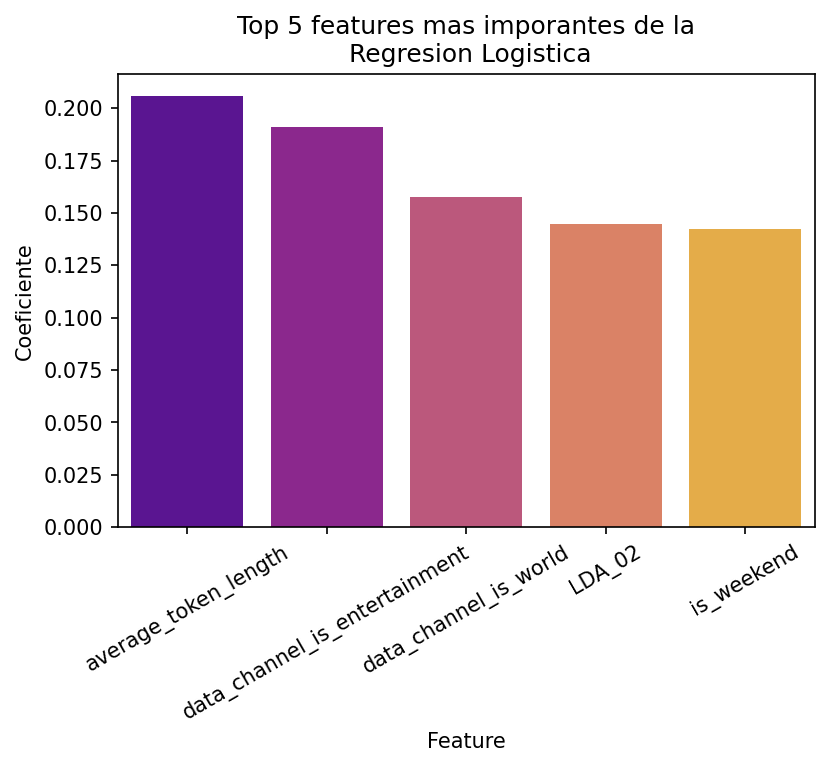

In [78]:
plt.figure(dpi=150)
sns.barplot(x=top_names, y=top_coef, palette='plasma')
plt.title("Top 5 features mas imporantes de la\n Regresion Logistica")
plt.ylabel("Coeficiente")
plt.xlabel("Feature")
plt.xticks(rotation=30)
plt.show()